# Exploring Twitch Streaming Data in Python
**Author:** Hanbin Go  
**Date:** 2025-05-20 

## Introduction
This is an **Exploratory Data Analysis** for Twitch's streaming and viewership trends. It was adapted from a prior analysis in R, available [here](https://hanbingo.github.io/twitch-user-growth-analysis/). This notebook will explore the same analysis in **Python**.

The goal of this analysis is to explore factors related to **streamer discoverability**, **platform engagement**, and to predict which streamers are most likely to experience **future growth** based on viewership history, game popularity, and streamer behaviour.

### Data Sources
- `Twitch_global_data.csv`: contained monthly aggregated statistics on overall Twitch viewership from January 2016 to September 2024, including metrics such as total hours watched, hours streamed, and average concurrent viewers.
- `Twitch_game_data.csv`: contained the top 200 games or categories on Twitch for each month from 2016 to September 2024.
- `Twitch_top_1000_streamers.csv`: Stats for top 1000 Twitch streamers (May 2024)

## Library Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

# Manual APA-like themes
sns.set_theme(style="whitegrid")
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1


## Load the Data

In [4]:
# import dataframe
global_df = pd.read_csv("./data/Twitch_global_data.csv")
game_df = pd.read_csv("./data/Twitch_game_data.csv", encoding="ISO-8859-1")
streamers_df = pd.read_csv("./data/Twitch_top_1000_streamers.csv")

#global_df.head()
#game_df.head()
#streamers_df.head()


## Data Cleaning & Preprocessing

In [5]:
# Convert all column names to lowercase
global_df.columns = global_df.columns.str.lower()
game_df.columns = game_df.columns.str.lower()
streamers_df.columns = streamers_df.columns.str.lower()

# Create a date column from year and month
global_df['date'] = pd.to_datetime(global_df['year'].astype(str) + '-' + global_df['month'].astype(str) + '-01')
game_df['date'] = pd.to_datetime(game_df['year'].astype(str) + '-' + game_df['month'].astype(str) + '-01')

# View cleaned data
#global_df.head()
#game_df.head()


## Dataset Overview

In [6]:
print("Global Twitch Data:")
display(global_df.head())

print("Top Games Data:")
display(game_df.head())

print("Top 1000 Streamers Data:")
display(streamers_df.head())


Global Twitch Data:


,year,month,hours_watched,avg_viewers,peak_viewers,streams,avg_channels,games_streamed,viewer_ratio,date
0,2016,1,480241904,646355,1275257,7701675,20076,12149,29.08,2016-01-01
1,2016,2,441859897,635769,1308032,7038520,20427,12134,28.98,2016-02-01
2,2016,3,490669308,660389,1591551,7390957,20271,12234,28.92,2016-03-01
3,2016,4,377975447,525696,1775120,6869719,16791,12282,28.80,2016-04-01
4,2016,5,449836631,605432,1438962,7535519,19394,12424,28.85,2016-05-01


Top Games Data:


,rank,game,month,year,hours_watched,hours_streamed,peak_viewers,peak_channels,streamers,avg_viewers,avg_channels,avg_viewer_ratio,date
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69.29,2016-01-01
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,2016-01-01
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104.26,2016-01-01
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169.29,2016-01-01
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03,2016-01-01


Top 1000 Streamers Data:


,rank,name,language,type,most_streamed_game,2nd_most_streamed_game,average_stream_duration,followers_gained_per_stream,avg_viewers_per_stream,avg_games_per_stream,total_time_streamed,total_followers,total_views,total_games_streamed,active_days_per_week,most_active_day,day_with_most_followers_gained
0,1,kaicenat,English,personality,Just Chatting,I'm Only Sleeping,7.6,18405,15852,2.3,4698,10600000,9150000,194,3.6,Friday,Saturday
1,2,jynxzi,English,personality,Tom Clancy's Rainbow Six Siege,NBA 2K20,5.4,3386,1145,1.2,8407,5760000,1950000,54,5.6,Tuesday,Sunday
2,3,caedrel,English,personality,League of Legends,I'm Only Sleeping,6.3,689,12331,1.3,6728,797000,14200000,111,2.8,Thursday,Sunday
3,4,caseoh_,English,personality,NBA 2K23,Just Chatting,4.6,7185,0,3.6,2554,4220000,53,385,6.2,Friday,Monday
4,5,ibai,Spanish,personality,Just Chatting,League of Legends,4.1,8289,190714,1.5,6865,15600000,359000000,149,4.3,Wednesday,Saturday


## Global Twitch Viewership from 2016 to 2024, and the impact of COVID-19
This section investigates long-term trends in Twitch usage and quantifies the impact of COVID-19 lockdowns on platform engagement.

## Visualization of Hours Watched Across the Years
This analysis computed the predicted hours watched for March and April 2020. March 2020 marked the initial implementation of COVID-19 lockdowns in many countries (the World Health Organization declared COVID-19 a global pandemic on March 11, 2020), whereas April 2020 represented the first full month of lockdowns for many countries.

A linear model was fit on pre-pandemic data to estimate what viewership might have looked like without the pandemic. This provides a clear way to detect deviations in actual viewership.

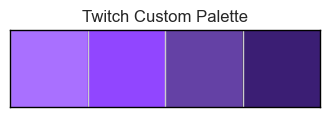

In [7]:
twitch_palette = ["#A970FF", "#9146FF", "#6441A5", "#3B1E74"]
sns.set_palette(twitch_palette)
sns.palplot(twitch_palette)
plt.title("Twitch Custom Palette", fontsize=12)
plt.show()

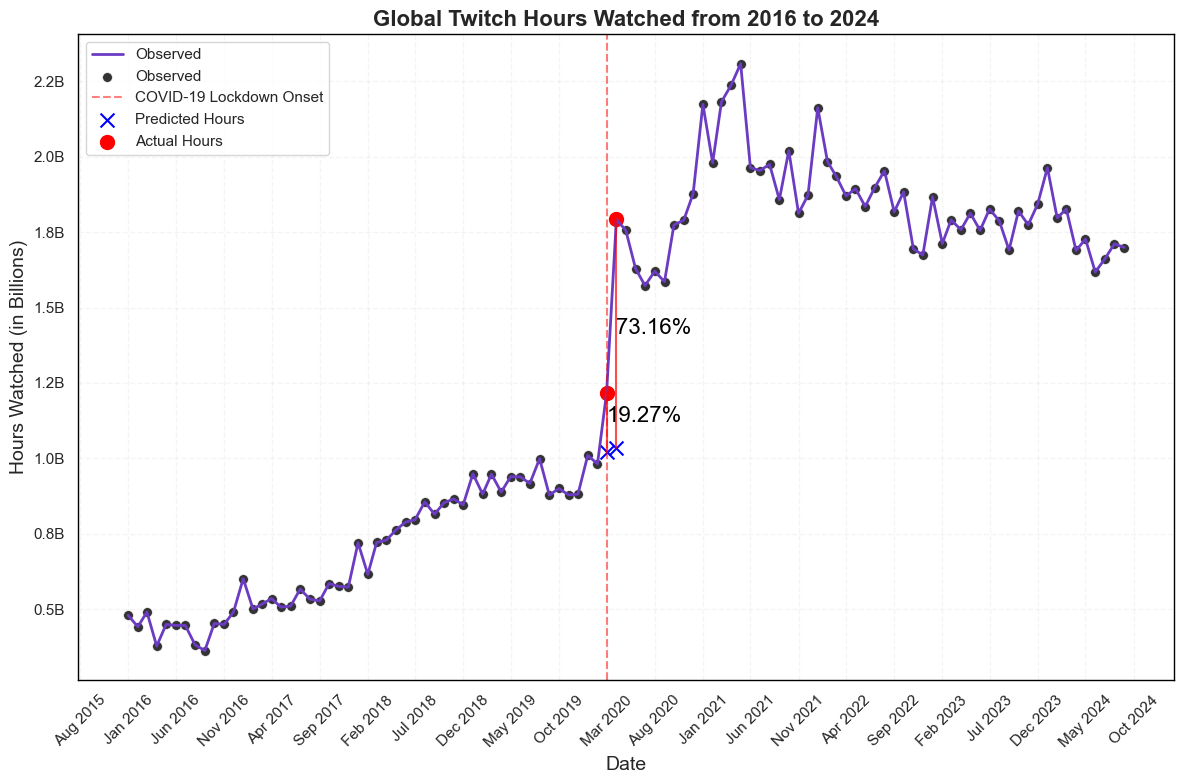

In [8]:
# Filter pre-COVID-19 data (up to February 2020)
precovid_global_df = global_df[global_df["date"] <= "2020-02-01"].copy() # Copy as I will be modifying the subset df

# Actual hours watched during COVID onset
covid_onset_dates = pd.to_datetime(["2020-03-01", "2020-04-01"])
covid_onset_df = global_df[global_df["date"].isin(covid_onset_dates)]
actual_hours = covid_onset_df["hours_watched"].values

# Fit linear model with pre-COVID data
# Transform dates into numerical values for the regression model
precovid_global_df["date_ordinal"] = precovid_global_df["date"].map(pd.Timestamp.toordinal)
x = sm.add_constant(precovid_global_df["date_ordinal"])
y = precovid_global_df["hours_watched"]
model = sm.OLS(y, x).fit()

# Predict for March and April 2020
predict_df = pd.DataFrame({"date": covid_onset_dates}) # Create a new df
predict_df["date_ordinal"] = predict_df["date"].map(pd.Timestamp.toordinal) # Convert to numeric
x_1 = sm.add_constant(predict_df["date_ordinal"])
predicted_hours = model.predict(x_1)

# Compute percentage difference
percent_delta = np.round(((actual_hours - predicted_hours) / predicted_hours) * 100, 2) # Round to two decimal places

# Create a new data frame for annotations
covid_impact_df = pd.DataFrame({
    "date": covid_onset_dates,
    "predicted_hours": predicted_hours,
    "actual_hours": actual_hours,
    "percent_delta": percent_delta
})

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=global_df, x=global_df["date"], y=global_df["hours_watched"]/1e9, color="#6b3bc3", linewidth=2, label="Observed")
sns.scatterplot(data=global_df, x=global_df["date"], y=global_df["hours_watched"]/1e9, color="#000000", s=50, label="Observed", alpha=0.8)

# V-line for COVID onset
plt.axvline(pd.to_datetime("2020-03-01"), color="red", linestyle="--", label="COVID-19 Lockdown Onset", alpha=0.5)

# Predicted vs Actual 
for i, row in covid_impact_df.iterrows():
    # Vertical segment
    plt.plot([row["date"], row["date"]],
             [row["predicted_hours"]/1e9, row["actual_hours"]/1e9],
             color="red", linewidth=1.5, alpha=0.7)
    # Points
    plt.scatter(row["date"], row["predicted_hours"]/1e9, color="blue", marker="x", s=100, label="Predicted Hours" if i == 0 else "")
    plt.scatter(row["date"], row["actual_hours"]/1e9, color="red", marker="o", s=100, label="Actual Hours" if i == 0 else "")
    # Text label
    mid_y = (row["predicted_hours"] + row["actual_hours"]) / 2 / 1e9
    plt.text(row["date"], mid_y, f"{row['percent_delta']:.2f}%", fontsize=16, ha="left", color="black")

# Plot labels
plt.title("Global Twitch Hours Watched from 2016 to 2024", fontsize=16, weight="bold")
plt.xlabel("Date", fontsize = 14)
# Set major ticks every 5 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel("Hours Watched (in Billions)", fontsize = 14)
plt.xticks(rotation = 45)
plt.grid(True, linestyle="--", alpha = 0.2)
plt.legend(loc="upper left")

# Format y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}B'))
plt.tight_layout()
plt.show()

The figure displays the global hours watched on Twitch from January 2016 to September 2024. Overall, viewership exhibited steady growth over time, with a notable deviation (sudden increase) in early 2020. The vertical dashed line marks March 2020, corresponding to the onset of COVID-19 lockdowns in many countries. Following this event, hours watched increased by **19.27%** in March relative to the predicted trend based on pre-pandemic data. In April 2020, during the first full month of widespread lockdowns, hours watched further increased by **73.16%**, reflecting a substantial surge in global Twitch engagement.

## Correlation between Hours Watched and Average Concurrent Viewers

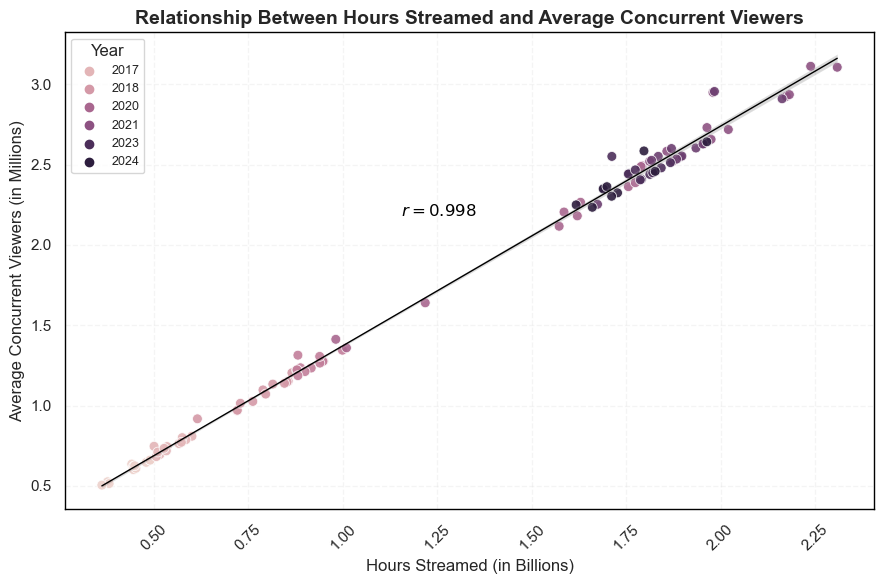

In [9]:
# Compute correlation
corr_hours_viewers_coef = pearsonr(global_df["hours_watched"], global_df["avg_viewers"]).statistic

# Plot 
plt.figure(figsize=(9, 6))
sns.scatterplot(data=global_df, x=global_df["hours_watched"]/1e9, y=global_df["avg_viewers"]/1e6, hue="year", alpha=0.9, s=50)
# Linear regression
sns.regplot(data=global_df,x=global_df["hours_watched"]/1e9, y=global_df["avg_viewers"]/1e6, scatter=False, color="black", line_kws={"linewidth": 1})
# Correlation annotation
plt.text(
    x=(global_df["hours_watched"].max() / 1e9) * 0.5,
    y=(global_df["avg_viewers"].max() / 1e6) * 0.7,
    s=f"$r = {corr_hours_viewers_coef:.3f}$",
    fontsize=12,
    color="black"
)
# Labels
plt.title("Relationship Between Hours Streamed and Average Concurrent Viewers", fontsize=14, weight="bold")
plt.xlabel("Hours Streamed (in Billions)", fontsize=12)
plt.ylabel("Average Concurrent Viewers (in Millions)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Year", loc="best", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

## Visualizing the Top 5 Games/Categories Across the Years
Top performing games are defined by the level of engagement across the years, in this case hours watched.

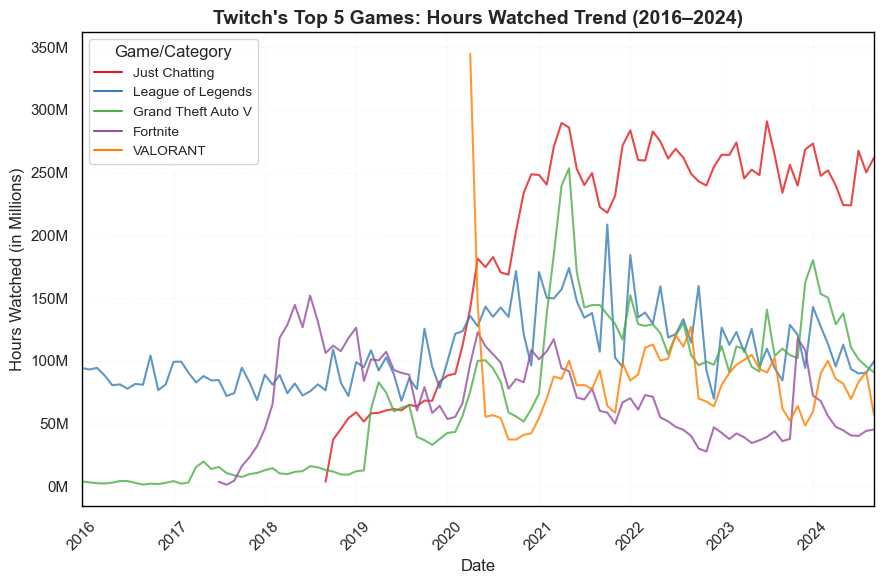

In [10]:
# Define top 5 games by total hours watched
top5_games = (
    game_df.groupby("game", as_index=False)
    .agg(total_hours_watched=("hours_watched", "sum"))
    .sort_values("total_hours_watched", ascending =False)
    .head(5)["game"]
    .tolist()
)

# Filter dataset for top 5 games only
top5_data = game_df[game_df["game"].isin(top5_games)].copy()

# Order game levels by the top game
top5_data["game"] = pd.Categorical(top5_data["game"], categories=top5_games, ordered=True)

# Plot hours watched as a function of time for top 5 games
plt.figure(figsize=(9, 6))
sns.lineplot(data=top5_data, x="date", y=top5_data["hours_watched"] / 1e6, hue="game", linewidth=1.5, alpha=0.8, palette="Set1")

# Add plot labels and legend
plt.title("Twitch's Top 5 Games: Hours Watched Trend (2016–2024)", fontsize=14, weight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Hours Watched (in Millions)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Game/Category", loc="best", fontsize=10)

# Format x-axis to show 1-year intervals
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xlim(pd.to_datetime("2016-01-01"), pd.to_datetime("2024-09-01"))

# Format y-axis labels with "M" suffix
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}M"))

# Final layout and display
plt.grid(True, linestyle="--", alpha=0.1)
plt.tight_layout()
plt.show()

## What Should Streamers Stream?
The following sections focus on individual streamer behaviours and the characteristics of successful streamers, based on the Top 1000 dataset.

## Who are the Top Streamers on Twitch?
Descriptive statistics were used to explore language use, content categories, and weekly activity patterns among top streamers.

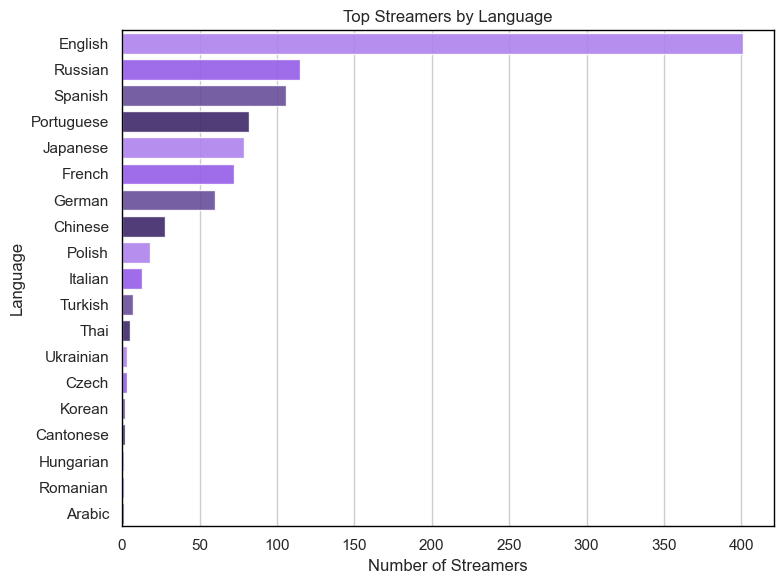

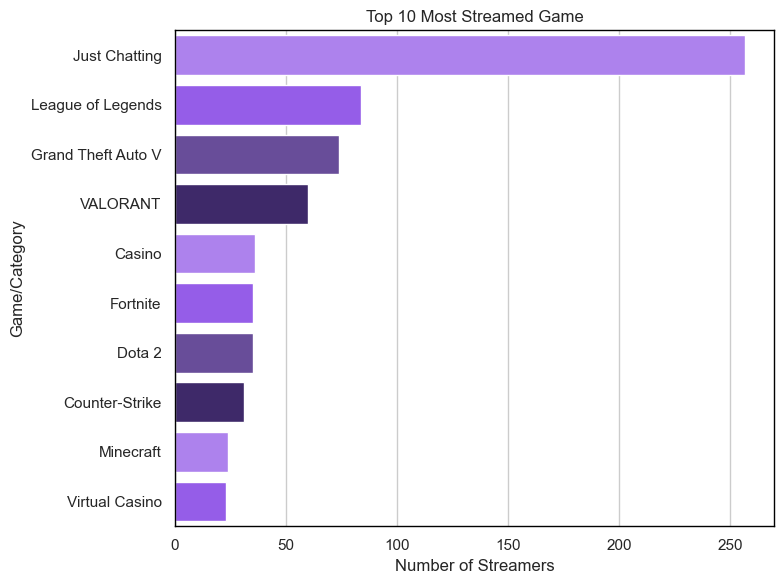

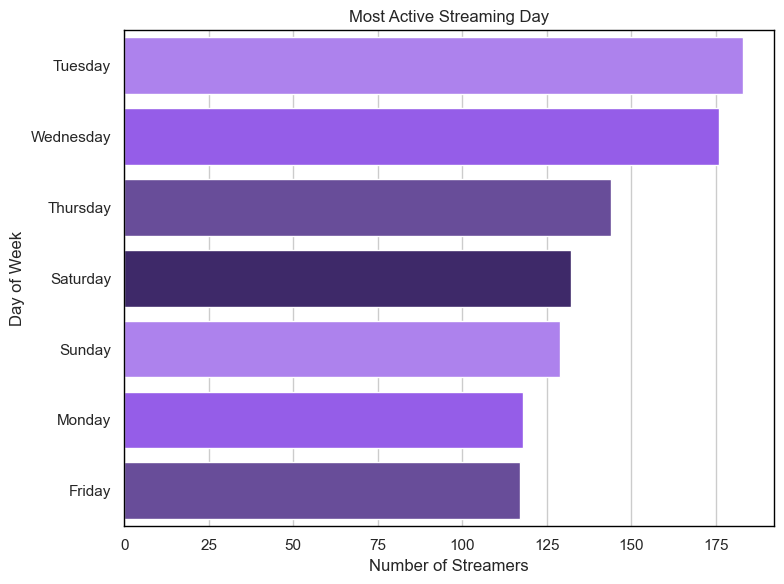

Text(0, 0.5, 'Day of Week')

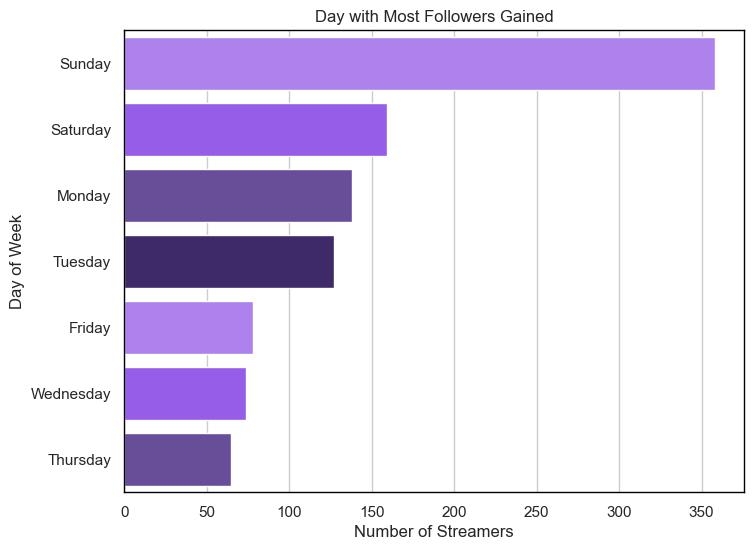

In [11]:
# language distribution
lang_counts = streamers_df["language"].value_counts().reset_index(name="count")
lang_counts.columns = ["language", "count"]

plt.figure(figsize=(8,6))
sns.barplot(data=lang_counts, x="count", y="language", palette=twitch_palette, alpha=0.9)
plt.title("Top Streamers by Language")
plt.xlabel("Number of Streamers")
plt.ylabel("Language")
plt.tight_layout()
plt.show()

# top 10 most streamed games
top_10_streamed = streamers_df["most_streamed_game"].value_counts().reset_index(name="count")
top_10_streamed.columns = ["most_streamed_game", "count"]
top_10_streamed = top_10_streamed.head(10)

plt.figure(figsize=(8,6))
sns.barplot(data=top_10_streamed, x="count", y="most_streamed_game", palette=twitch_palette)
plt.title("Top 10 Most Streamed Game")
plt.xlabel("Number of Streamers")
plt.ylabel("Game/Category")
plt.tight_layout()
plt.show()

# most active streaming day
count_active_streaming_days = streamers_df["most_active_day"].value_counts().reset_index(name="count")
count_active_streaming_days.columns = ["most_active_day", "count"]
plt.figure(figsize=(8,6))
sns.barplot(data=count_active_streaming_days, x="count", y="most_active_day", palette=twitch_palette)
plt.title("Most Active Streaming Day")
plt.xlabel("Number of Streamers")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

# day with most followers gained
count_most_gained = streamers_df["day_with_most_followers_gained"].value_counts().reset_index(name="count")
count_most_gained.columns = ["day_with_most_followers_gained", "count"]
plt.figure(figsize=(8,6))
sns.barplot(data=count_most_gained,x="count", y="day_with_most_followers_gained", palette=twitch_palette)
plt.title("Day with Most Followers Gained")
plt.xlabel("Number of Streamers")
plt.ylabel("Day of Week")

## Correlation Matrix: Top 1000 Twitch Streamers. Assessing Relationships Between Behavioural Metrics

To examine potential multicollinearity and select key predictors for modelling, I computed the Pearson correlation matrix among continuous behavioural variables. These correlations help assess which behavioural variables (e.g., average stream duration, average number of viewers) may jointly influence follower growth and should be considered in the mixed model.

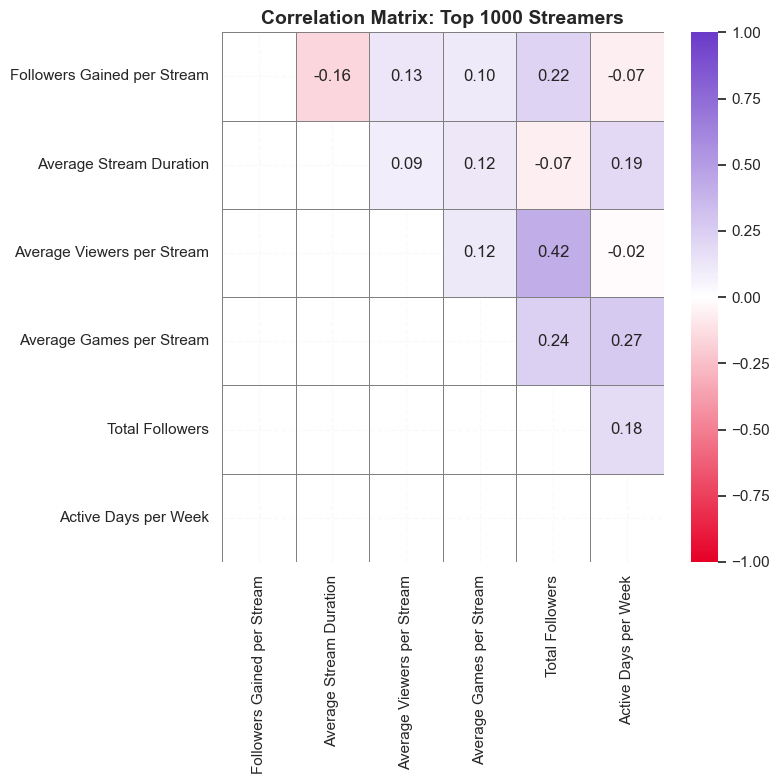

In [48]:
# Select numeric columns of interestand compute correlation matrix
streamers_df_num = streamers_df[
    ["followers_gained_per_stream",
    "average_stream_duration",
    "avg_viewers_per_stream",
    "avg_games_per_stream",
    "total_followers",
    "active_days_per_week"]
    ].rename(columns={
    "followers_gained_per_stream": "Followers Gained per Stream",
    "average_stream_duration": "Average Stream Duration",
    "avg_viewers_per_stream": "Average Viewers per Stream",
    "avg_games_per_stream": "Average Games per Stream",
    "total_followers": "Total Followers",
    "active_days_per_week": "Active Days per Week"
})

# Compute correlation matrix
corr_matrix = streamers_df_num.corr()

# Custom red-white-purple gradient
from matplotlib.colors import LinearSegmentedColormap
red_purple = LinearSegmentedColormap.from_list("red_purp", ["#e60026", "#ffffff", "#6b3bc9"])

# Plot correlation heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, mask=np.tril(np.ones_like(corr_matrix, dtype=bool)),  # upper triangle only
            cmap=red_purple, annot=True, fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, linecolor='gray')
plt.title("Correlation Matrix: Top 1000 Streamers",fontsize=14, weight="bold")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.1)
plt.show()


Plotting histograms to visualize the normality of each of the variables of interest.

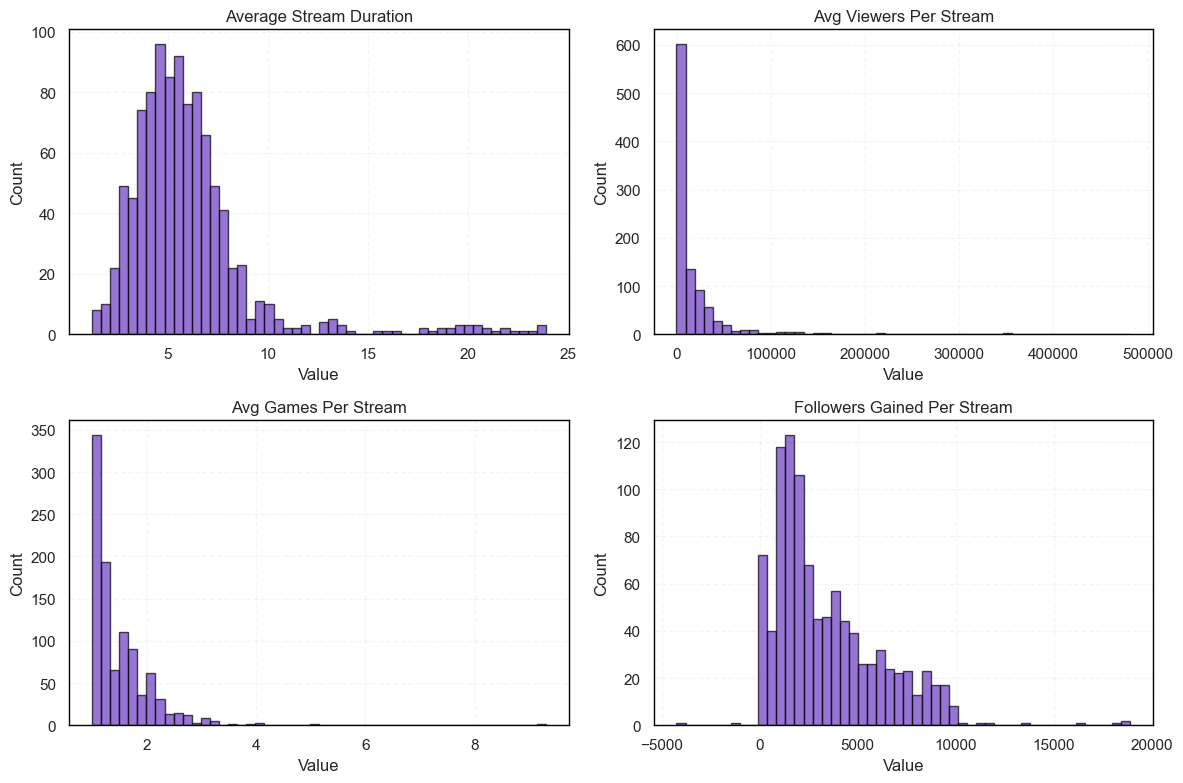

In [13]:
# Select relevant cols
cols = ["average_stream_duration", "avg_viewers_per_stream", "avg_games_per_stream", "followers_gained_per_stream"]

# Set up 2 by 2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten axes to loop
axes = axes.flatten()
# Plot each histogram
for i, col in enumerate(cols):
    axes[i].hist(streamers_df[col], bins=50, color="#6b3bc3", edgecolor="black", alpha=0.7)
    axes[i].set_title(col.replace("_", " ").title())
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Count")
    axes[i].grid(True, linestyle="--", alpha=0.2)

plt.tight_layout()
plt.show()

Right skewed, so variables such as average viewers per stream and average games per stream can benefit from logarithmic transformation, but for simplicity of interpretation, I move forward without any transformations.

## What Drives Followers Growth? (Linear Mixed Effects Model)
A linear mixed-effects model was used to predict the number of followers gained per stream based on average viewers per stream, average stream duration, and average games per stream, while accounting for random intercepts by streamers’ most-streamed game.

In [14]:
from statsmodels.formula.api import mixedlm
# Fit null random intercept model
null_model = mixedlm("followers_gained_per_stream ~ 1", data=streamers_df, groups=streamers_df["most_streamed_game"]).fit()
print(null_model.summary())

# Extract variance components
var_group = null_model.cov_re.iloc[0, 0]     # Random intercept variance
var_resid = null_model.scale                 # Residual variance

# Compute ICC
icc = var_group / (var_group + var_resid)
print(f"ICC: {icc:.3f}")

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: followers_gained_per_stream
No. Observations: 999     Method:             REML                       
No. Groups:       105     Scale:              7020201.1584               
Min. group size:  1       Log-Likelihood:     -9303.4829                 
Max. group size:  257     Converged:          Yes                        
Mean group size:  9.5                                                    
---------------------------------------------------------------------------
                 Coef.      Std.Err.     z      P>|z|    [0.025     0.975] 
---------------------------------------------------------------------------
Intercept        3109.462    149.408   20.812   0.000   2816.628   3402.296
Group Var      535817.005     79.637                                       

ICC: 0.071


The intraclass correlation coefficient (ICC = 0.07) from the null model suggests that approximately 7% of the variance in follower gain can be attributed to differences across streamed game categories. While this value was relatively low, including a random intercept was justified, as different content categories may inherently vary in baseline levels of followers gained.

In [15]:
# Fit the lme with predictors
lme_model = mixedlm(
    "followers_gained_per_stream ~ avg_viewers_per_stream + average_stream_duration + avg_games_per_stream",
    data=streamers_df,
    groups=streamers_df["most_streamed_game"]
).fit()

print(lme_model.summary())

                  Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: followers_gained_per_stream
No. Observations:  999     Method:             REML                       
No. Groups:        105     Scale:              6938294.7800               
Min. group size:   1       Log-Likelihood:     -9283.0844                 
Max. group size:   257     Converged:          Yes                        
Mean group size:   9.5                                                    
--------------------------------------------------------------------------
                          Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------------
Intercept                 3277.117  283.286 11.568 0.000 2721.887 3832.348
avg_viewers_per_stream       0.008    0.002  3.969 0.000    0.004    0.012
average_stream_duration   -122.995   29.866 -4.118 0.000 -181.531  -64.458
avg_games_per_stream       352.466  165.022 

Average Viewers per stream was a significant positive predictor of follower gain. Conversely, average stream duration was negatively associated with follower gain. Lastly, average games per stream was also a significant positive predictor.

## Not All Top Streamers Grow the Same Way: Grouping Different Growth Strategies of Top 1000 Streamers

Used k-means clustering to identify latent behavioural grouping among the top 1000 streamers. Variables included, average viewers per stream, average stream duration, and active days per week. The three variables were chosen to focus on the average engagement and the streamer’s commitment/effort. PCA was used to reduce the three dimensions to two for plotting This analysis highlighted varied paths to success.

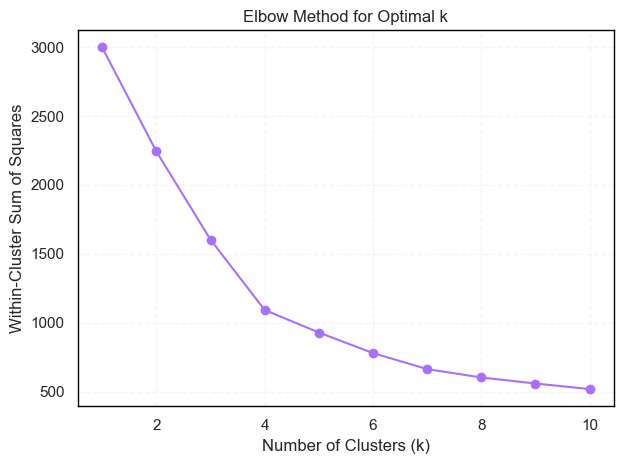

In [46]:
# prepare features for clustering
cluster_df = streamers_df[["avg_viewers_per_stream", "average_stream_duration", "active_days_per_week"]].dropna()
scaled_df = StandardScaler().fit_transform(cluster_df)  # standardize for k-means

# elbow method to find optimal number of clusters
wss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=30, n_init=10)
    kmeans.fit(scaled_df)
    wss.append(kmeans.inertia_)  # total within-cluster sum of squares

# plot elbow curve
plt.plot(range(1, 11), wss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares")
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

In [17]:
# run k-means with k = 4 based on elbow point
kmeans = KMeans(n_clusters=4, n_init=50, random_state=2025)  # reproducibility, 50 starts
labels = kmeans.fit_predict(scaled_df)

# assign cluster to original dataframe
streamers_df = streamers_df.loc[cluster_df.index].copy()  # align indices
streamers_df["cluster"] = labels

# label and categorize the streamer categories
label_map = {
    0: "Efficient Casual Streamers",
    1: "Very Active Streamers",
    2: "Long-Hours Grinders",
    3: "Top Streamer Stars"
}
streamers_df["cluster_label"] = streamers_df["cluster"].map(label_map)

# table of summary of key behaviours by cluster
cluster_table = (
    streamers_df
    .groupby(["cluster", "cluster_label"], as_index=False)
    .agg({
        "avg_viewers_per_stream": "mean",
        "average_stream_duration": "mean",
        "active_days_per_week": "mean",
        "followers_gained_per_stream": "mean",
        "cluster": "count"
    })
    .rename(columns={"cluster": "n"})
)
# print table
from IPython.display import display
display(cluster_table.round(2))

,cluster_label,avg_viewers_per_stream,average_stream_duration,active_days_per_week,followers_gained_per_stream,n
0,Efficient Casual Streamers,12042.64,4.82,1.89,3578.40,402
1,Very Active Streamers,16634.76,5.92,4.89,3284.97,537
2,Long-Hours Grinders,13334.15,18.04,3.60,1911.80,40
3,Top Streamer Stars,263405.60,7.50,2.98,5052.30,20


## PCA plot

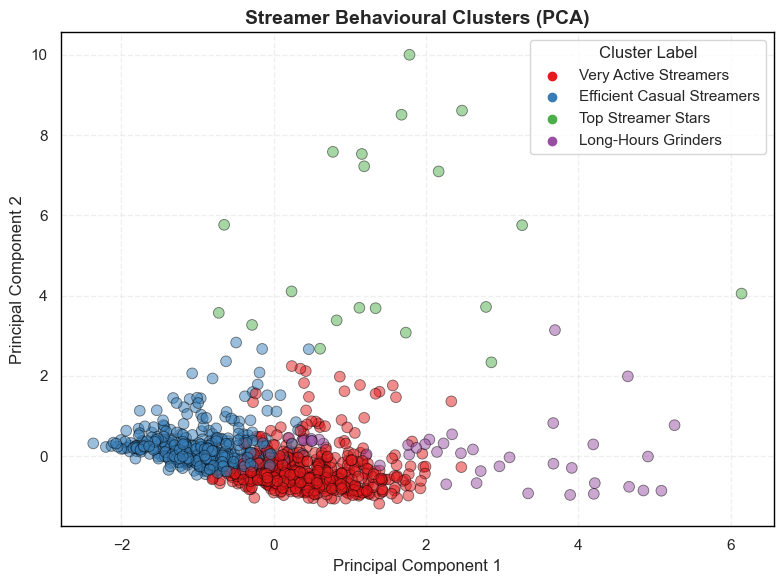

In [21]:
label_map = {
    0: "Efficient Casual Streamers",
    1: "Very Active Streamers",
    2: "Long-Hours Grinders",
    3: "Top Streamer Stars"
}

# Run PCA for scaled_df
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    "PC1": pca_result[:, 0],
    "PC2": pca_result[:, 1],
    "Cluster": [label_map[i] for i in labels]  # map numeric to labels
})

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="Cluster", palette="Set1", s=60, edgecolor="black", alpha=0.5)

plt.title("Streamer Behavioural Clusters (PCA)", fontsize=14, weight="bold")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster Label", loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

Clusters revealed distinct streamer classifications, including consistent active streamers, casual, yet efficient streamers, long-hours broadcasters, and top-tier stars. The post-hoc analysis revealed varying follower gain efficiency.

These results highlight that most streamers achieve success through consistent activity, with short-to-moderate stream durations (e.g., 5 hours per stream), along with more efficient part-time streamers also emerge. long-hour streamers, while highly active, may face diminishing follower returns.

## Compare Cluster Distributions

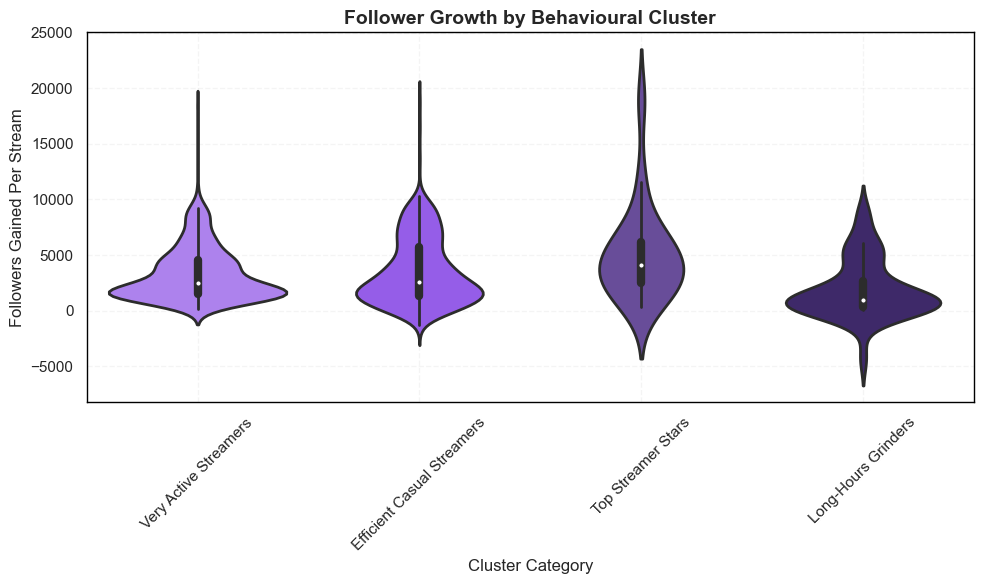

In [44]:
plt.figure(figsize=(10, 6))

# Violin plot
sns.violinplot(data=streamers_df, x="cluster_label", y="followers_gained_per_stream", inner="box", linewidth=2, alpha=0.6)

# Labels
plt.title("Follower Growth by Behavioural Cluster", fontsize=14, weight="bold")
plt.xlabel("Cluster Category")
plt.ylabel("Followers Gained Per Stream")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

The distribution of follower gains varied significantly by behavioural cluster. Notably, Efficient Casual Streamers achieved higher average follower gains with shorter and less frequent streams, while Long-Hours Grinders, despite streaming for much longer durations, saw diminishing returns. This suggests that consistent, focused engagement can outperform excessive stream duration when it comes to follower growth.



##  Conclusion

In summary, follower growth on Twitch was shaped by behavioural consistency, content strategy, and stream duration, rather than total hours or audience size. While global viewership increased substantially during the pandemic, sustained growth required deliberate creator strategies. The top 1000 streamers were predominantly Very Active Streamers, averaging 4.8 days per week and 5.9 hours per session. However, Efficient Casual Streamers, who streamed only 1.9 days per week for 4.8 hours on average, achieved high follower gains per stream. This pattern demonstrated that shorter, well-targeted sessions were often more effective.

Streaming on Sundays was also associated with greater follower growth. These results suggest that moderate, focused effort combined with interactive content, such as Just Chatting, supports follower acquisition more effectively than consistently long-duration streams. For platforms such as Patreon, prioritizing features that encourage engagement (e.g., Just Chatting), content variety, and weekly consistency may help creators sustain long-term audience growth. Direct audience interaction through conversational formats can be especially effective when the primary objective is user engagement and entertainment.